# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">HOUSE PRICES</p>

---

#### **DESCRIPTION:**

_Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence._

#### **TASK:**

_With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home._

#### **SEE MORE HERE:**

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

---

#### **TABLE OF CONTENTS:**

* [**1. QUICK LOOK AT THE DATSET**](#quick-look)
  
* [**2. EXPLORATORY DATA ANALYSIS (EDA)**](#eda)
  
  - [**2.1. HANDLE WITH CATEGORICAL FEATURES**](#handling-categories)
  
  - [**2.2. WHAT WE HAVE LEARNED ABOUT CATEGORICAL FEATURES**](#categories-quick-summary)
  
  - [**2.3. HANDLE WITH CATEGORICAL FEATURES**](#handling-numerical)
  
  - [**2.4. WHAT WE HAVE LEARNED ABOUT NUMERICAL FEATURES**](#numerical-quick-summary)
  
* [**3. PRELIMINARY DATA PREPROCESSING**](#pre-data-preproc)
  
  - [**3.1. CUSTOM CATEGORICAL TRANSFORMERS**](#custom-cat-transformers)

  - [**3.2. CUSTOM NUMERICAL TRANSFORMERS**](#custom-num-transformers)
  
  - [**3.3. LOT FRONTAGE IMPUTATION**](#lot-frontage-imput)

* [**4. AUTO PREPROCESSING PIPELINES**](#auto-preproc)
  
* [**5. MACHINE LEARNING**](#ml)

---

<a id="quick-look"></a>
# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">1. QUICK LOOK AT THE DATASET</p>

---

Minimal setup.

In [720]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.
DARK_BLUE = "#141b4d"

MY_RC = {
    "axes.labelcolor": DARK_BLUE,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": DARK_BLUE,
    "ytick.labelsize": 10,
    "ytick.color": DARK_BLUE,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": DARK_BLUE,
}

sns.set_theme(rc=MY_RC)


Okay, so load this dataset.

In [721]:
train_path = "data/train.csv"
test_path = "data/test.csv"

if ON_KAGGLE:
    train_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
    test_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

pd.options.display.max_columns = train_set.shape[1]


Firstly, let's have a look at categorical and numerical features here.

In [722]:
train_cats = train_set.select_dtypes(include="object")
train_nums = train_set.select_dtypes(include="number")

assert train_cats.shape[1] + train_nums.shape[1] == train_set.shape[1]


In [723]:
train_cats.head()


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [724]:
train_nums.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


Let's save categorical and numerical columns.

In [725]:
cat_cols = train_cats.columns
num_cols = train_nums.columns


In [726]:
print(*cat_cols, sep=", ")


MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition


In [727]:
print(*num_cols, sep=", ")


Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, SalePrice


In [728]:
print(
    f"Number of categorical features: {len(cat_cols)}",
    f"Number of numerical features: {len(num_cols)}",
    sep="\n",
)


Number of categorical features: 43
Number of numerical features: 38


Uhh, a lot of it. Let's see the missing values yet.

In [729]:
train_cats.isna().sum()[train_cats.isna().sum() > 0]


Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [730]:
train_nums.isna().sum()[train_nums.isna().sum() > 0]


LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

Okay, so we have lots of missing values, especially in the categorical features. How it looks in the test set?

In [731]:
test_cats = test_set.select_dtypes(include="object")
test_nums = test_set.select_dtypes(include="number")


In [732]:
test_cats.isna().sum()[test_cats.isna().sum() > 0]


MSZoning           4
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageFinish      78
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [733]:
test_nums.isna().sum()[test_nums.isna().sum() > 0]


LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64

Unfortunately, here it is a little bit worse than in the train set.

---

<a id="eda"></a>
# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">2. EXPLORATORY DATA ANALYSIS (EDA)</p>

---

<a id="handling-categories"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 2.1. HANDLE WITH CATEGORICAL FEATURES </span></b>

We have a lot of features in this dataset. It would be good to have some nice tool to take a look at the categories first. To do this, we will write a class `CategoricalFeatureHandler`, which helps us a little. The main task of this class will be to present relationships between a given categorical feature and the chosen numerical one. The most important for us is obviously `SalePrice`, so we will compare each categorical one with that.

In [734]:
from textwrap import wrap

from matplotlib.gridspec import GridSpec
from pandas.api.types import is_numeric_dtype, is_object_dtype
from scipy.stats import percentileofscore


class CategoricalFeatureHandler:
    """Provides a piece of information about the categorical feature
    in a more pleasant manner. See `create_categories_info()` and
    `categories_info_plot()` methods."""

    def __init__(self, dataset):
        """Initialize the handler by copying the original `dataset`."""
        self.df = dataset.copy()

    def create_categories_info(self, cat_feature, num_feature):
        """Creates a new Data Frame with `cat_feature` categories
        with respect to `num_feature`"""
        df = self.df

        if not is_object_dtype(df[cat_feature]):
            raise TypeError("The `cat_feature` is not a `object` dtype.")
        if not is_numeric_dtype(df[num_feature]):
            raise TypeError("The `num_feature` is not a `numeric` dtype.")

        df[cat_feature].fillna("Missing", inplace=True)

        info_df = (
            df.groupby(cat_feature)
            .agg(
                Median=(num_feature, np.nanmedian),
                Mean=(num_feature, np.nanmean),
                RelMeanDiff=(
                    num_feature,
                    lambda x: (np.nanmean(x) - np.nanmedian(x)) / np.nanmedian(x) * 100
                    if np.nanmedian(x) > 0
                    else 0,
                ),
            )
            .add_prefix(f"{num_feature} ")
        )

        # What percentile of the whole `num_feature` constitutes
        # the calculated median / mean for a given category?
        for measure in ("Median", "Mean"):
            non_nan_values = df.loc[~df[num_feature].isna(), num_feature]
            info_df[f"{num_feature} {measure}Pctl."] = [
                percentileofscore(non_nan_values, score)
                for score in info_df[f"{num_feature} {measure}"]
            ]

        info_df["Counts"] = df[cat_feature].value_counts()
        info_df["Counts Ratio"] = df[cat_feature].value_counts(normalize=True)
        self.info_df = info_df
        self._provide_consistent_cols_order()

        return self.info_df.copy()

    def _provide_consistent_cols_order(self):
        """Adds private attributes to pass column names easily. Changes the
        column order in the `info_df` to be more precise. This operation is
        not required but simplifies navigation in `_draw_descriptive_stats()`."""
        (
            self._median_name,
            self._mean_name,
            self._rel_mean_diff_name,
            self._median_pctl_name,
            self._mean_pctl_name,
            self._counts_name,
            self._counts_ratio_name,
        ) = self.info_df.columns

        self.info_df = self.info_df[
            [
                self._counts_name,
                self._counts_ratio_name,
                self._median_name,
                self._median_pctl_name,
                self._mean_name,
                self._mean_pctl_name,
                self._rel_mean_diff_name,
            ]
        ]

        self._n_categories_in = self.info_df.shape[0]
        self._n_stats_in = self.info_df.shape[1]
        self._stat_names_in = self.info_df.columns

    def categories_info_plot(self, cat_feature, num_feature, palette="mako_r"):
        """Creates a new figure with bar plots and descriptive statistics.
        The figure height is scalable with a large number of categories."""
        self.create_categories_info(cat_feature, num_feature)

        fig_height = 8
        if self._n_categories_in > 5:
            fig_height += (self._n_categories_in - 5) * 0.5

        fig = plt.figure(figsize=(12, fig_height), tight_layout=True)
        sns.set_palette(palette, self._n_categories_in)
        plt.suptitle(
            f"{cat_feature} vs {self._counts_name} & {self._median_name} & {self._rel_mean_diff_name}"
        )
        gs = GridSpec(nrows=2, ncols=3, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])  # Counts.
        ax2 = fig.add_subplot(gs[0, 1])  # Median.
        ax3 = fig.add_subplot(gs[0, 2])  # Relative Mean Diff.
        ax4 = fig.add_subplot(gs[1, :])  # Descriptive Stats.

        for ax, stat_name in zip(
            (ax1, ax2, ax3),
            (self._counts_name, self._median_name, self._rel_mean_diff_name),
        ):
            self._plot_category_vs_stat_name(ax, stat_name)
            if not ax == ax1:
                plt.ylabel("")

        self._draw_descriptive_stats(ax4)
        sns.set_palette("deep")  # Default palette.

    def _plot_category_vs_stat_name(self, ax, stat_name):
        """Plots a simple barplot (`category` vs `stat_name`) in the current axis."""
        info_df = self.info_df
        order = info_df.sort_values(stat_name, ascending=False).index
        plt.sca(ax)
        plt.yticks(rotation=30)
        sns.barplot(data=info_df, x=stat_name, y=info_df.index, order=order)

    def _draw_descriptive_stats(self, ax4):
        """Draws info from the `info_df` at the bottom of the figure."""
        plt.sca(ax4)
        plt.ylabel("Descriptive Statistics", fontsize=12, weight="bold")
        plt.xticks([])
        plt.yticks([])

        # Spaces between rows and cols. Default axis has [0, 1], [0, 1] range,
        # thus we divide 1 by number of necessary rows / columns.
        xspace = 1 / (self._n_stats_in + 1)  # +1 due to one for a category.
        yspace = 1 / (self._n_categories_in + 1 + 1)  # +2 due to wide header.

        xpos = xspace / 2
        ypos = 1 - yspace
        wrapper = lambda text, width: "\n".join(line for line in wrap(text, width))

        for header in np.r_[["Category"], self._stat_names_in]:
            header = wrapper(header, 15)  # Wrap headers longer than 15 characters.
            plt.text(xpos, ypos, header, ha="center", va="center", weight="bold")
            xpos += xspace

        """Provide formatting for the stats section. The `itertuples()` method iterates over 
        DataFrame rows as named tuples, so each row (tuple) contains one element from 
        each column. We can unpack this tuple in the `format()` method using *args syntax. 
        Therefore each component will be formatted with the defined pattern. Nevertheless,
        values compose one string. Thus we use the `split()` method later. This way, we can 
        easily plot info from the data frame using a fancy format. The only drawback is that 
        you must know the order of the columns."""

        pattern = "{};{};{:.2%};{:,.1f};{:.0f};{:,.1f};{:.0f};{:+.2f}"
        category_stats = [pattern.format(*row) for row in self.info_df.itertuples()]

        for i, cat_stats in enumerate(category_stats):
            ypos = 1 - (5 / 2 + i) * yspace
            plt.axhline(ypos + yspace / 2, color="white", linewidth=5)
            for j, cat_stat in enumerate(cat_stats.split(";")):
                xpos = (1 / 2 + j) * xspace
                plt.text(xpos, ypos, cat_stat, ha="center", va="center")


So what exactly does it do? First of all, we have two main methods here: `create_categories_info()` and `categories_info_plot()`. The first is responsible for creating useful statistics of categorical feature in relation to numerical one. It calculates the counts and counts ratio of each category in the categorical one. But it is obvious. The more interesting is that it computes the median and mean values of a numerical feature related to available categories. Additionally, it evaluates percentiles of that medians and means with respect to the whole numerical feature. I will illustrate this with an example. 

Let's draw an example plot.

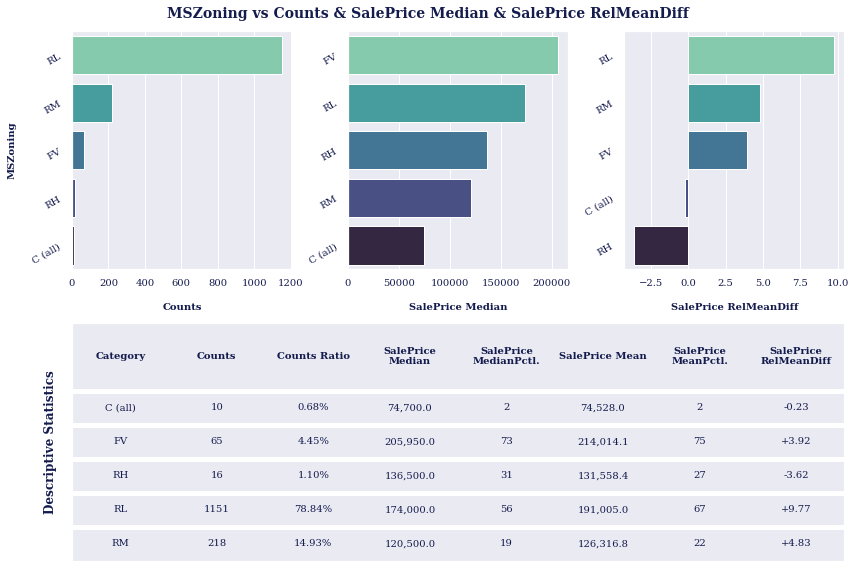

In [735]:
category_handler = CategoricalFeatureHandler(train_set)
category_handler.categories_info_plot("MSZoning", "SalePrice")


Thus, in `MSZoning`, we have five categories `C (all)`, `FV`, `RH`, `RL`, and `RM`. I think there is no need to explain the counts and counts ratio. Let's take a look at the `SalePriceMedian` column. For example median of house prices that have the `RM` category equals 120,500. This median price is the 19th percentile of all prices in the dataset, which means that probably houses in the _Residential Medium Density_ zone (RM) are cheaper than in the overall. In a similar way   `SalePriceMean` and `SalePriceMeanPctl.` columns work. We have the `SalePriceRelMeanDiff` column yet. The relative mean difference is defined as 

$$\textrm{RelMeanDiff} = \frac{\textrm{Mean} - \textrm{Median}}{\textrm{Median}} * 100.$$

For example, in the `RM` category mean house price is higher than the median price by around 5%. After we draw such a plot, we can also see these stats in the `info_df` attribute.

In [736]:
category_handler.info_df


,Counts,Counts Ratio,SalePrice Median,SalePrice MedianPctl.,SalePrice Mean,SalePrice MeanPctl.,SalePrice RelMeanDiff
MSZoning,,,,,,,
C (all),10,0.006849,74700.0,1.643836,74528.000000,1.643836,-0.230254
FV,65,0.044521,205950.0,72.602740,214014.061538,75.205479,3.915543
RH,16,0.010959,136500.0,30.684932,131558.375000,26.506849,-3.620238
RL,1151,0.788356,174000.0,56.301370,191004.994787,67.191781,9.772986
RM,218,0.149315,120500.0,18.595890,126316.830275,21.849315,4.827245


When we don't want to draw a plot and are only interested in stats, we can call the `create_categories_info()` method with desired features.

In [737]:
category_handler.create_categories_info("LotConfig", "SalePrice")


,Counts,Counts Ratio,SalePrice Median,SalePrice MedianPctl.,SalePrice Mean,SalePrice MeanPctl.,SalePrice RelMeanDiff
LotConfig,,,,,,,
Corner,263,0.180137,160000.0,48.595890,181623.425856,62.260274,13.514641
CulDSac,94,0.064384,199262.0,70.068493,223854.617021,77.808219,12.341850
FR2,47,0.032192,165000.0,51.267123,177934.574468,58.972603,7.839136
FR3,4,0.002740,195450.0,68.972603,208475.000000,73.356164,6.664108
Inside,1052,0.720548,159697.5,48.013699,176938.047529,58.424658,10.795753


This class should be helpful not only for this dataset. I've tested it for the titanic too. It should also be scalable. For example, try to call it with the `Neighborhood` feature. Our main task at this moment is to just get through each categorical feature with this class and see what we have there in relation to `SalePrice`.

---

<a id="categories-quick-summary"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 2.2. WHAT WE HAVE LEARNED ABOUT CATEGORIES </span></b>

There we have the first attempt to understand these features.

#### **HOUSE SITUATION:**

- `LotShape` - _General shape of property._  
  A interesting feature with four categories. It's reasonable to join the `IR1`, `IR2`, and `IR3` categories into one. Houses with these categories have similar median and mean prices. Thus we'll obtain two categories, `IR` (irregular) and `Reg` (regular), so the OneHotEncoder should be fine. Curiously houses with irregular shapes of property have higher prices.
- `LotConfig` - _Lot configuration._  
  The `FR3` category has only four counts. We can probably merge it with `FR2`. OneHotEncoder is appropriate, I think.
- `LandContour` - _Flatness of the property._  
  Large imbalance in favour of `Lvl` (Near Flat/Level). It has around 90% of the counts. It's difficult to say something, but there is a significant gap between prices for `HLS` and `Low` vs `Bnk`. It's something which resembles grading, so the OrdinalEncoder should probably be used.
- `MSZoning` - _Identifies the general zoning classification of the sale._  
  Here, we have five imbalanced categories. The `RL` (_Residential Low Density_) category account for almost 79% of the entire feature. Moreover, the mean `SalePrice` for this category is around 10% higher than the median, so we have a slight asymmetry here. The median `SalePrice` is 174000, constituting the 56th percentile of all prices. The second most frequent category is `RM` (_Residential Medium Density_), about 15% of total counts. Prices are much lower here; the median price is 120500, the 19th percentile of all prices. The highest prices are for `FV` (_Floating Village Residential_) (65 counts - 4.5%). Here we have prices where the median is 205950 and the mean is 214014, which constitutes the 73rd and 75th percentile, respectively. Perhaps we should encode this feature with OneHotEncoder, but the `Residential` categories are graded, so maybe OrdinalEncoder? 
- `Neighborhood` - _Physical locations within Ames city limits._  
  Here we have a lot of categories. It's probably something like districts. In my opinion, we may join these categories in regards to `SalePrice` median in these districts and create buckets. For example, in the "VeryRich" bucket, we put these houses where the `SalePrice` median is above 250000. In the "Rich," we put these with 200000 - 250000, and so on. Next, we can use OrdinalEncoder.
- `Condition1` - _Proximity to various conditions._  
  Imbalance in favour of the `Norm` category (around 86%). Here are several categories that can possibly be merged (based on their descriptions). For example, `PosA` with `PosN`, `RRAe` with `RRAn`, and `RRNe` with `RRNn`. Then we use OneHotEncoder.

#### **HOUSE STYLE:**

- `BldgType` - _Type of dwelling_.  
  Here are two similar categories, i.e. `Twnhs` and `TwnhsE`, that have the potential to merge, but the median and mean sale prices for them have a significant difference. Moreover, `TwnhsE` has regular distribution, meanwhile `Twnhs` has not. Probably we should leave it as it is. This feature represents different types of buildings, so the OneHotEncoder is a good choice.
- `HouseStyle` - _Style of dwelling._  
  Here it's possible we can merge `1Story` with `1.5Fin` and `1.5Unf`. Similarly, with `2Story`, `2.5Fin` and `2.5Unf`. Remain two categories, i.e. `SFoyer` and `SLvl`. It's a split style, so that we could merge them too. Then encode these categories with OneHotEncoder. 
- `RoofStyle` - _Type of roof._  Relatively high imbalance of categories (78% of counts only for `Gable`). Let's leave this as it is and encode with OneHotEncoder.
- `Exterior1st` - _Exterior covering on house._  
  Here we have lots of features. The most frequent is `VinylSd` (around 35% of counts). We could probably merge some of them, but I have no idea how. Maybe these with Shingle's postfix into one, Siding postfix into one, and so on. But something like that might not work; nevertheless we can always set merging such features in an `if` statement, so the algorithm assesses if it's better or not. In case when we leave it and encode it with OneHotEncoder, there will be a sparse matrix for sure. However, we'll use OneHotEncoder anyway.
- `MasVnrType` - _Masonry veneer type._   
  There are 8 missing values. It's reasonable to fill them with most frequent strategy. We can join `BrkCmn` with `BrkFace`. Then use OneHotEncoder.
- `ExterQual` - _Evaluates the quality of the material on the exterior._  
  It's ordinary grading (Excellent, Good, Average,...). We will just use OrdinalEncoder.
- `ExterCond` - _Evaluates the present condition of the material on the exterior._  
  Similarly as for `ExterQual` - OrdinalEncoder.
- `Foundation` - _Type of foundation._  
  It represents different types of foundations. I don't know what to do with this, so we will just encode it with OneHotEncoder.
- `PavedDrive` - _Paved driveway_. Here we have `Y` (Paved), `P` (Partial Pavement) and `N` (Dirt/Gravel), so probably OrdinalEncoder will be fine.

#### **HOUSE ELEMENTS:**

- `HeatingQC` - _Heating quality and condition._  
  It's ordinary grading (Excellent, Good, Average,...). It's nothing to do here, just OrdinalEncoder.
- `CentralAir` - _Central air conditioning._  
  Whether the house has air conditioning or not. Here is an imbalance for `Y` (93%), but probably it's better to leave this feature. Houses without air conditioning have lower prices.
- `Electrical` - _Electrical system._  
  Again we have an imbalance here. Over 91% of counts constitute the `SBrkr` category. Reading the description, I think we may merge `FuseA`, `FuseF`, `FuseF` and `Mix` into one category and encode that feature with OneHotEncoder.
- `KitchenQual` - _Kitchen quality._  
  It's ordinary grading (Excellent, Good, Average,...), so the OrdinalEncoder will be fine.
- `FireplaceQu` - _Fireplace quality_.  
  Simple grading, but we have around 47% of missing values here. Nevertheless, there is a numerical feature, i.e. `Fireplaces` without missing values. This means we can fill in missing in `FireplaceQu`. Then we use OrdinalEncoder.

#### **BASEMENT:**

- `BsmtQual` - _Evaluates the height of the basement._  
  Grading of the basement (Excellent, Good,...), so the OrdinalEncoder for sure. 
- `BsmtCond` - _Evaluates the general condition of the basement._  
  Similarly as above.
- `BsmtExposure` - _Refers to walkout or garden level walls._  
  Similarly as above.
- `BsmtFinType1` - _Rating of basement finished area._  
  Similarly as above but different grades.

In general, we have missing values in all the above features. We could fill in these with the most frequent strategy, but there is probably a better choice. The dataset has a feature `TotalBsmtSF` without missing values. We can fill these missing values with "NA" (no basement), where the `TotalBsmtSF` == 0. 

#### **GARAGE:**

- `GarageType` - _Garage location._  
  I think we can leave it as it is. The most frequent category is `Attchd` (attached to the home), around 60% of counts. The second is `Detchd`, around 27%. These are different types of locations, so the OneHotEncoder should be good.
- `GarageFinish` - _Interior finish of the garage._  
  Not bad distribution of categories (41%, 29%, 24%) and around 6% of missing. This feature says whether the garage is finished or not (or partially finished), so perhaps OneHotEncoder should be used.
- `GarageQual` - _Garage quality._  
  Grading of the garage (Excellent, Good,...). Here is quite an imbalance in favour of `TA` category (around 90% of counts), but we may leave it and use OrdinalEncoder.
- `GarageCond` - _Garage condition._  
  Similarly as above.

Again, as for the basement, there are missing values. Also, similarly as there, the dataset is equipped with a helpful feature, i.e. `GarageArea` without NaN values. We can use the same strategy as for the basement. If the garage area equals zero, it means there is no garage, so we fill in the missing values with "NA" (no garage).

#### **OTHER:**

- `SaleType` - _Type of sale._  
  From the description, we may join warranty categories, i.e. `WD`, `CWD`, `VWD`, contract categories, i.e. `Con`, `ConLw`, `ConLI`, `ConLD` and `COD`, `Oth`. We should leave the `New` category for sure. It has not bad number of counts (around 8%), and it's easy to observe these houses are expensive. Then, we will use OneHotEncoder.
- `SaleCondition` - _Condition of sale._  
  Probably we should leave it as it is and use OneHotEncoder.

#### **TO DROP PROBABLY:**

- `Street` - _Type of road access to property._  
  Huge imbalance. The `Pave` category constitutes about 99.6%. We'll drop this feature.
- `Alley` - _Type of alley access to property._  
  Here is a similar situation but on the other way. We have 94% missing values. We'll drop this feature.
- `Utilities` - _Type of utilities available._  
  There are two categories and the second one has only one count, so the feature should be dropped for sure.
- `Condition2` - _Proximity to various conditions (if more than one is present)._  
  Huge imbalance (99% of all counts) for only one category. We'll drop this.
- `Heating` - _Type of heating._  
  Huge imbalance (98%) for `GasA`. We'll drop this feature.
- `PoolQC` - _Pool quality_.  
  There is too significant imbalance (99.5%) of missing values. At this moment we should drop this.
- `Fence` - _Fence quality_.  
  There we have around 81% of missing values. We should probably drop this. In the dataset, there is no other feature related to Fence.
- `MiscFeature` - _Miscellaneous feature not covered in other categories_.  
  Again too many missing values (96%). We should drop this at this moment.
- `Functional` - _Home functionality (Assume typical unless deductions are warranted)_.  
  Imbalance. Probably this feature should be dropped.
- `RoofMatl` - _Roof material_.  
  A Huge imbalance (98%) in favour of one category, `CompShg`. We should drop this feature.
- `LandSlope` - _Slope of property._  
  Here we have three graded categories but with large imbalance in favour of `Gtl` (around 95% of counts). I think we should drop this, but when we leave it, then the OrdinalEncoder should be used.
- `Exterior2nd` - _Exterior covering on house (if more than one material)._  
  This is the second material on the exterior. As I can see, houses have the same material here in 85% of cases. I mean, there is 85% of samples fulfilling the condition that `Exterior1st` == `Exterior2nd`. We can probably drop this feature and leave only the `Exterior1st`.
- `BsmtFinType2` - _Rating of basement finished area (if multiple types)._  
  At this time, it's most similar to `BsmtFinType1`, so I will drop this, but I may be wrong.

---

<a id="handling-numerical"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 2.3. HANDLE WITH NUMERICAL FEATURES </span></b>

In [738]:
train_set.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


First, it's good to see how the correlation matrix looks and which features are strongly linear dependent.

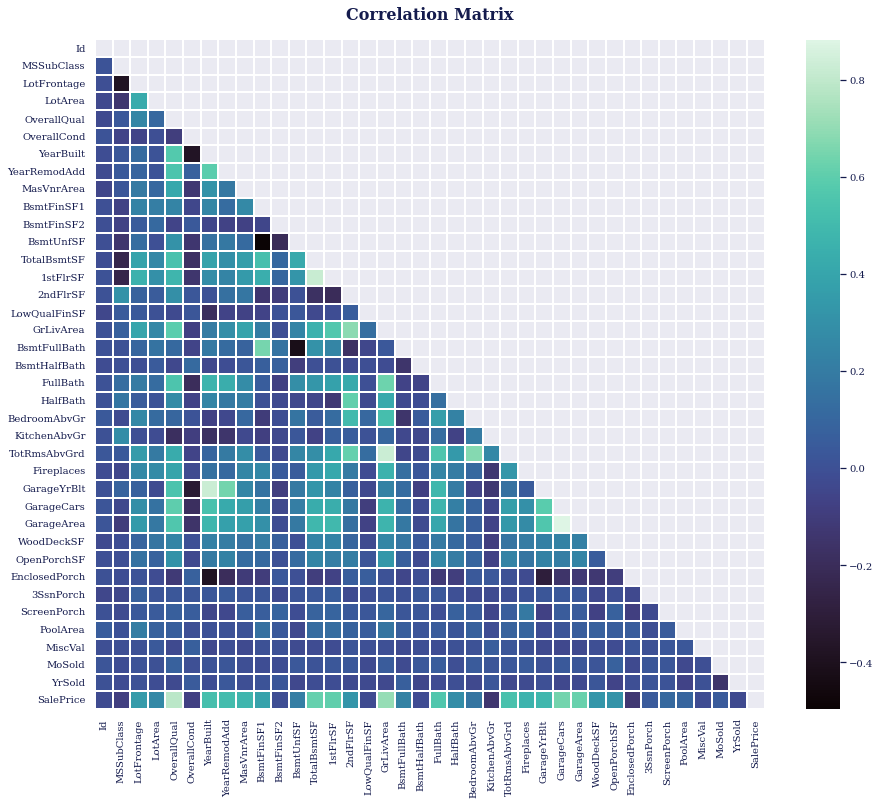

In [739]:
corr = train_set.corr()
triu_mask = np.triu(corr)

plt.figure(figsize=(15, 15))
sns.heatmap(
    corr,
    square=True,
    linewidths=2,
    annot=False,
    mask=triu_mask,  # Lower triangle.
    cbar_kws={"shrink": 0.82},
    cmap="mako",
)
plt.title("Correlation Matrix", fontsize=16, pad=20)
plt.show()

So we can see several interesting relations here. For example it seems that `TotRmsAbvGrd` and `GrLivArea` are strongly correlated. The next are `GarageYrBlt` vs `YearBuilt`, `1stFlrSF` vs `TotalBsmtSF` and `GarageArea` vs `GarageCars`. When we take a while to think, these relations are obvious, maybe not with `1stFlrSF` vs `TotalBsmtSF` only. Let's have a look at how high these correlations actually are.

In [740]:
# The `:<` expression means built-in f-string `ljust()` method.
print(
    f"{'TotRmsAbvGrd vs GrLivArea:':<25}",
    f"{corr.loc['TotRmsAbvGrd', 'GrLivArea']:.5f}",
)


TotRmsAbvGrd vs GrLivArea: 0.82549


In [741]:
print(
    f"{'GarageYrBlt vs YearBuilt:':<25}",
    f"{corr.loc['GarageYrBlt', 'YearBuilt']:.5f}",
)


GarageYrBlt vs YearBuilt: 0.82567


In [742]:
print(
    f"{'1stFlrSF vs TotalBsmtSF:':<25}",
    f"{corr.loc['1stFlrSF', 'TotalBsmtSF']:.5f}",
)


1stFlrSF vs TotalBsmtSF:  0.81953


In [743]:
print(
    f"{'GarageArea vs GarageCars:':<25}",
    f"{corr.loc['GarageArea', 'GarageCars']:.5f}",
)


GarageArea vs GarageCars: 0.88248


Let's see how it looks in relation to `SalePrice` yet.

In [744]:
corr["SalePrice"].sort_values(ascending=False)


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

We know from the correlation matrix that not all features are probably necessary. For example, we see `GrLivArea` has a stronger correlation with `SalePrice` than `TotRmsAbvGrd`, and these two features are highly related too, so we can probably take only `GrLivArea` at the final stage. Similarly, with the three remaining examples from above. On the other hand, perhaps we needn't drop them, and they will be helpful in feature engineering.

Now we will write a class which helps us a little with numerical features and show the relations between them.

In [745]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr


class NumericalFeatureHandler:
    def __init__(self, dataset):
        self.df = dataset.copy()

    def create_numerical_info(self, num_feature1, num_feature2, include_zeros=True):
        if not is_numeric_dtype(self.df[num_feature1]):
            raise TypeError("The `num_feature1` is not a `numeric` dtype.")
        if not is_numeric_dtype(self.df[num_feature2]):
            raise TypeError("The `num_feature2` is not a `numeric` dtype.")

        feat1, feat2 = self.df[num_feature1], self.df[num_feature2]

        if not include_zeros:
            no_zeros = ~(np.isclose(feat1, 0) | np.isclose(feat2, 0))
            feat1, feat2 = feat1[no_zeros], feat2[no_zeros]

        log_feat1, log_feat2 = np.log1p(feat1), np.log1p(feat2)

        self.info_ = self._calculate_info(feat1, feat2)
        self.log_info_ = self._calculate_info(log_feat1, log_feat2)

        self.feat1, self.feat2 = feat1, feat2
        self.log_feat1, self.log_feat2 = log_feat1, log_feat2

        # return pd.DataFrame(
        #     [self.info_, self.log_info_],
        #     index=[self.feat1.name, f"log1p({self.feat1.name})"],
        # )

    def _calculate_info(self, feat1, feat2):
        no_nan = ~(feat1.isna() | feat2.isna())

        q3, q1 = np.percentile(feat1[no_nan], [75, 25])
        IQR = q3 - q1
        upper_bound = q3 + 1.5 * IQR
        lower_bound = q1 - 1.5 * IQR

        outliers_no = ((feat1 < lower_bound) | (feat1 > upper_bound)).sum()
        corr, _ = pearsonr(feat1[no_nan], feat2[no_nan])
        mutual_info = mutual_info_regression(
            feat1[no_nan].values.reshape(-1, 1), feat2[no_nan], random_state=42
        )

        return {
            "Min": feat1.min(),
            "Max": feat1.max(),
            "Mean": feat1.mean(),
            "Median": feat1.median(),
            "Std": feat1.std(),
            "25th Pctl.": q1,
            "75th Pctl.": q3,
            "1.5 IQR": 1.5 * IQR,
            "Outliers": outliers_no,
            f"{feat2.name} Corr": corr,
            f"{feat2.name} MI": mutual_info[0],
        }

    def numerical_info_plot(self, num_feature1, num_feature2, include_zeros=True):
        self.create_numerical_info(num_feature1, num_feature2, include_zeros)

        fig = plt.figure(figsize=(12, 8), tight_layout=True)
        plt.suptitle(f"{self.feat1.name} Informations")
        gs = GridSpec(
            nrows=3,
            ncols=3,
            figure=fig,
            height_ratios=(0.2, 0.4, 0.4),
            width_ratios=(0.35, 0.35, 0.3),
        )

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
        ax4 = fig.add_subplot(gs[1, 1], sharex=ax2)
        ax5 = fig.add_subplot(gs[2, 0], sharex=ax1)
        ax6 = fig.add_subplot(gs[2, 1], sharex=ax2)
        ax7 = fig.add_subplot(gs[:, 2])

        # ax1.ticklabel_format(axis='both', style='sci', scilimits=(3, 3))
        # ax3.ticklabel_format(axis='both', style='sci', scilimits=(-3, -3))
        # ax5.ticklabel_format(axis='both', style='sci', scilimits=(3, 3))

        feat1, feat2 = self.feat1, self.feat2
        log_feat1, log_feat2 = self.log_feat1, self.log_feat2

        self._draw_boxplots((feat1, log_feat1), (ax1, ax2))
        self._draw_histograms((feat1, log_feat1), (ax3, ax4))
        self._draw_regplots((feat1, log_feat1), (feat2, log_feat2), (ax5, ax6))
        self._draw_stats(ax7)

        plt.show()

    def _draw_boxplots(self, features, axes):
        medianprps = {"color": "yellowgreen"}
        boxprps = {"alpha": 0.7, "color": "navy"}
        flierprps = {"marker": "x", "mec": "navy", "mfc": "navy", "alpha": 0.7}

        for feat, ax in zip(features, axes):
            plt.sca(ax)
            sns.boxplot(
                x=feat, flierprops=flierprps, medianprops=medianprps, boxprops=boxprps
            )
            plt.xlabel("")

    def _draw_histograms(self, features, axes):
        for feat, ax in zip(features, axes):
            plt.sca(ax)
            sns.histplot(x=feat, stat="density", color="navy", alpha=0.7)
            sns.kdeplot(x=feat, fill=True, linewidth=2, color="yellowgreen")
            plt.xlabel("")

        plt.sca(axes[1])
        plt.ylabel("")

    def _draw_regplots(self, features1, features2, axes):
        skws = {"alpha": 0.5, "s": 5, "color": "navy"}
        lkws = {"linewidth": 3, "linestyle": "--", "color": "yellowgreen"}

        for feat1, feat2, ax in zip(features1, features2, axes):
            plt.sca(ax)
            sns.regplot(x=feat1, y=feat2, scatter_kws=skws, line_kws=lkws)
            if ax == axes[1]:
                plt.xlabel(f"log1p({feat1.name})")
                plt.ylabel(f"log1p({feat2.name})")

    def _draw_stats(self, ax7):
        plt.sca(ax7)
        plt.ylabel(f"Descriptive Statistics", fontsize=12, weight="bold")
        plt.xticks([])
        plt.yticks([])

        xpos, xspace = 0.1, 0.55
        yspace = 1 / (2 * (len(self.info_) + 2))
        ypos1, ypos2 = 1.0 - yspace, 0.5 - yspace

        plt.text(0.5, ypos1, "Default Stats", ha="center", va="center", weight="bold")
        for key, value in self.info_.items():
            ypos1 -= yspace
            plt.text(xpos, ypos1, f"{key}:", va="center")
            plt.text(xpos + xspace, ypos1, f"{value:.3f}", va="center")

        plt.axhline(0.5, linewidth=10, color="white")

        plt.text(0.5, ypos2, "Log1p Stats", ha="center", va="center", weight="bold")
        for key, value in self.log_info_.items():
            ypos2 -= yspace
            plt.text(xpos, ypos2, f"{key}:", va="center")
            plt.text(xpos + xspace, ypos2, f"{value:.3f}", va="center")


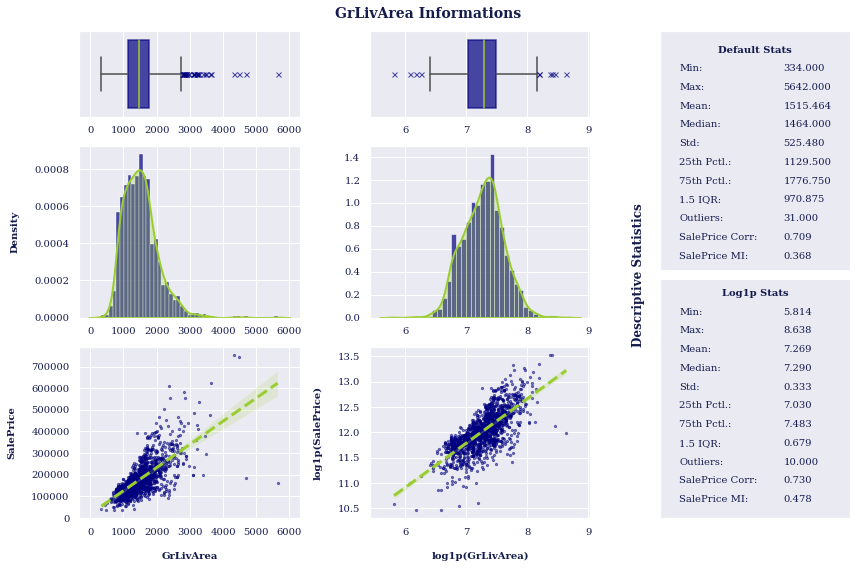

In [746]:
numerical_handler = NumericalFeatureHandler(train_set)
numerical_handler.numerical_info_plot("GrLivArea", "SalePrice")


Okay, so what does it do? Generally, that class creates six plots. The whole thing is related to `num_feature1` in general. On the top, we see boxplots of the default feature (on the left) and log1p of this (on the right). A similar matter is there with the histograms in the centre. At the bottom, there are regression plots. We draw a regression plot, i.e. `num_feature1` vs `num_feature2` in the default scale (on the left) and in the log1p scale (on the right). Such plots give us quite nice information about linear dependency.

Moreover, on the right side of the figure, we have a few statistics about `num_feature1` in these two different scales. For example, the `SalePrice Corr` says what correlation there is between `GrLivArea` and `SalePrice`. The MI abbr. means mutual information. Additionally, we can set `include_zeros` to `False` in the `numerical_info_plot()` method. Thus plots and statistics won't include them.

Well, we need to get through all numerical features with an instance of that class and see what we have there.

---

<a id="numerical-quick-summary"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 2.4. WHAT WE HAVE LEARNED ABOUT NUMERICAL FEATURES </span></b>

#### **BASEMENT:**

- `TotalBsmtSF` - _Total square feet of basement area._  
  We have several zeros here, around 2.5%. Probably log transformation should be acceptable.
- `BsmtUnfSF` - _Unfinished square feet of basement area._  
  Here we have a slightly different situation because around 8% of the whole feature consists of zeros. When we transform it with a log, we have a peak in zero. Perhaps the square root transformation will be better. Otherwise, we can split this feature into two distinct categories: 1 - has an unfinished square area, and 0 - does not have an unfinished square area.
- `BsmtFinSF1` - _Type 1 finished square feet._  
  Around 32% of the feature are zeros. 
- `BsmtFinSF2` - _Type 2 finished square feet._  
  Around 89% of the feature are zeros. 
- `BsmtFullBath` - _Basement full bathrooms._  
  Here we have integer values (0, 1, 2, 3), where almost the whole feature is composed of 0 and 1.
- `BsmtHalfBath` - _Basement half bathrooms._  
  Similarly, as in `BsmtFullBath`, we have integer values here (0, 1, 2), and zeros compose around 94% of counts.

So again, we should probably transform `TotalBsmtSF` with the `log1p`. When we look at `BsmtUnfSF` + `BsmtFinSF1` + `BsmtFinSF2`, it turns out that it is equal to `TotalBsmtSF`, so I think all these features are not necessary here. In my opinion, we may do something like that: we add `BsmtFinSF1` and `BsmtFinSF2` and encode this new feature when it's equal to `TotalBsmtSF` or not. It means that the basement is finished or not. In this case, the `BsmtUnfSF` is redundant, and we drop this. We can do the same for `BsmtFullBath` and `BsmtHalfBath`. We add these and encode whether there is a bath or not. I think it's a reasonable approach.

#### **LOT:**

- `LotFrontage` - _Linear feet of street connected to property._  
  At first glance, we have two outliers here (`LotFrontage` > 300). The `log1p` distribution looks quite good and reduces outliers' impact, so this transformation should be fine. At first glance, we have here two outliers (`LotFrontage` > 300). The `log1p` distribution looks quite good and reduces outliers' impact, so this transformation should be fine. Moreover, there are 259 missing values (18% of the whole dataset). When we look at the correlation matrix and use our numerical handler to create a `LotFrontage` vs `LotArea` comparison, we see that there is probably a better way to fill in these NaNs. We can build a linear regression model to predict missing values, which will be operated on logarithms. 
- `LotArea` - _Lot size in square feet._  
  Again, we have several outliers here (`LotArea` > 100000). Log distribution looks good, so we transform it to log and reduce outliers' influence.

#### **GARAGE:**

- `GarageArea` - _Size of garage in square feet._  
  Similarly, as in the `BsmtUnfSF` and `TotalBsmtSF`. Around 5.5% of zeros.
- `GarageYrBlt` - _Year garage was built._  
- `GarageCars` - _Size of garage in car capacity._  
  Integers values (0, 1, 2, 3, 4). The 2 value prevails with 56% of total counts.

In this case, it's good to look at the correlation matrix. We can see a huge correlation between `GarageArea` and `GarageCars`, which is reasonable. The second superb correlation is between `GarageYrBlt` and `YearBuilt`. That is obvious too. Again we probably don't need these three features. `GarageCars` has a higher correlation with `SalePrice` than `GarageArea`, so I leave only this feature.

#### **DECK & PORCH:**

- `WoodDeckSF` - _Wood deck area in square feet._
  About 52% of values are zeros. The rest is various but positive. It's an excellent example of creating a binary feature, i.e. whether there is a wood deck or not.
- `OpenPorchSF` - _Open porch area in square feet._
- `EnclosedPorch` - _Enclosed porch area in square feet._
- `3SsnPorch` - _ Three season porch area in square feet._
- `ScreenPorch` - _Screen porch area in square feet._

In the case of different types of a porch, I think we can add them all up and create binary feature too. Whether there is a porch or not.

#### **ROOMS:**

- `FullBath` - _Full bathrooms above grade._  
  Integer values (0, 1, 2, 3). I have no idea at this moment, so leave it.
- `HalfBath` - _Half baths above grade._  
  Integer values (0, 1, 2). We can create a binary feature, whether there is a half bathroom or not.
- `BedroomAbvGr` - _Bedrooms above grade (does NOT include basement bedrooms)._  
  Integer values (0 - 8). I think I leave it as it is. The most frequent values is 3 (55%)
- `KitchenAbvGr` - _Kitchens above grade._  
  About 95% of the feature is composed of 1, so we can drop this.
- `TotRmsAbvGrd` - _Total rooms above grade (does not include bathrooms)._  
  Integer values (2 - 14). As we can see at correlation matrix, there is a huge correlation with `GrLivArea`, so I will drop this feature.
- `1stFlrSF` - _First Floor square feet._  
  High correlation with `TotalBsmtSF`. `TotalBsmtSF` has a higher correlation with `GrLivArea` so I leave it and drop `1stFlrSF`.
- `2ndFlrSF` - _Second floor square feet._  
  About 56% are zeros, so we may create a binary feature.
- `GrLivArea` - _Above grade (ground) living area square feet._  
  At first glance, we have two outliers here (`GrLivArea` > 4000 and `SalePrice` < 300000). We see the log transformation works pretty good and reduces outliers' impact. Here is a very high correlation with `SalePrice`.

#### **OTHER:**

- `MasVnrArea` - 
- `Fireplaces` - 
- `OverallQual` - 
- `OverallCond` - 
- `YearBuilt` - 
- `YrSold` - 

#### **TO DROP PROBABLY:**

- `LowQualFinSF` - usunąć
- `PoolArea` - usunąć
- `MiscVal` - usunąć
- `MoSold` - usunąć
- `YearRemodAdd` - usunąć
- `MSSubClass` - usunąć
- 
- `SalePrice` - to nasz target, zastosowac log

---

<a id="pre-data-preproc"></a>
# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">3. PRELIMINARY DATA PREPROCESSING</p>

---

<a id="custom-cat-transformers"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 3.1. CUSTOM CATEGORICAL TRANSFORMERS </span></b>

Firstly, we will write the `CustomImputer` class to automatically fill in missing values related to the basement, garage and fireplaces.

In [747]:
from sklearn.base import BaseEstimator, TransformerMixin, check_is_fitted


In [748]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")

        check_is_fitted(self)
        X = X.copy()

        garage_mask = np.isclose(X["GarageArea"], 0)
        garage_cats = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
        X.loc[garage_mask, garage_cats] = "NA"
        X.loc[garage_mask, "GarageCars"] = 0
        X.loc[garage_mask, "GarageYrBlt"] = X.loc[garage_mask, "YearBuilt"]

        bsmt_mask = np.isclose(X["TotalBsmtSF"], 0)
        bsmt_cats = [
            "BsmtQual",
            "BsmtCond",
            "BsmtExposure",
            "BsmtFinType1",
            "BsmtFinType2",
        ]
        bsmt_nums = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]
        X.loc[bsmt_mask, bsmt_cats] = "NA"
        X.loc[bsmt_mask, bsmt_nums] = 0

        X.loc[np.isclose(X["Fireplaces"], 0), "FireplaceQu"] = "NA"

        return X


Now let's think about the `Neighborhood` feature. As I mentioned, there are many categories, and we can probably do something better here. Let's create a bucket of districts' affluence.

In [749]:
districts_affluence = pd.cut(
    train_set[["Neighborhood", "SalePrice"]]
    .groupby("Neighborhood")
    .median()["SalePrice"],
    bins=5,
    labels=["Poor", "BelowAverage", "Average", "AboveAverage", "Rich"],
)
districts_affluence


Neighborhood
Blmngtn         Average
Blueste    BelowAverage
BrDale             Poor
BrkSide            Poor
ClearCr         Average
CollgCr         Average
Crawfor         Average
Edwards            Poor
Gilbert         Average
IDOTRR             Poor
MeadowV            Poor
Mitchel    BelowAverage
NAmes      BelowAverage
NPkVill    BelowAverage
NWAmes          Average
NoRidge            Rich
NridgHt            Rich
OldTown            Poor
SWISU      BelowAverage
Sawyer     BelowAverage
SawyerW         Average
Somerst    AboveAverage
StoneBr            Rich
Timber     AboveAverage
Veenker         Average
Name: SalePrice, dtype: category
Categories (5, object): ['Poor' < 'BelowAverage' < 'Average' < 'AboveAverage' < 'Rich']

In [750]:
train_set_copy = train_set.copy()
train_set_copy["DistrictsAffluence"] = train_set_copy["Neighborhood"].map(districts_affluence)
train_set_copy["DistrictsAffluence"].value_counts(normalize=True)

Average         0.320548
BelowAverage    0.263014
Poor            0.233562
Rich            0.097945
AboveAverage    0.084932
Name: DistrictsAffluence, dtype: float64

Now we will write another custom class to transform some categorical features. 

In [751]:
class CustomCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")

        check_is_fitted(self)
        X = X.copy()

        self._transform_lot_shape(X)
        self._transform_lot_config(X)
        self._transform_mas_vnr_type(X)
        self._transform_bldg_type(X)
        self._transform_house_style(X)
        self._transform_condition1(X)
        self._transform_sale_type(X)
        self._transform_electrical(X)
        self._transform_neighborhood(X)

        return X

    def _transform_lot_shape(self, X):
        lot_shape_mask = X["LotShape"].isin(("IR1", "IR2", "IR3"))
        X.loc[lot_shape_mask, "LotShape"] = "IR"

    def _transform_lot_config(self, X):
        lot_config_mask = X["LotConfig"].isin(("FR2", "FR3"))
        X.loc[lot_config_mask, "LotConfig"] = "FR"

    def _transform_mas_vnr_type(self, X):
        brk_mask = X["MasVnrType"].isin(("BrkFace", "BrkCmn"))
        X.loc[brk_mask, "MasVnrType"] = "Brick"

    def _transform_bldg_type(self, X):
        twnhs_mask = X["BldgType"].isin(("TwnhsE", "Twnhs"))
        X.loc[twnhs_mask, "BldgType"] = "Twnhs"

    def _transform_house_style(self, X):
        story1_mask = X["HouseStyle"].isin(("1Story", "1.5Fin", "1.5Unf"))
        story2_mask = X["HouseStyle"].isin(("2Story", "2.5Fin", "2.5Unf"))
        X.loc[story1_mask, "HouseStyle"] = "1Story"
        X.loc[story2_mask, "HouseStyle"] = "2Story"

    def _transform_condition1(self, X):
        rra_mask = X["Condition1"].isin(("RRAe", "RRAn"))
        rrn_mask = X["Condition1"].isin(("RRNn", "RRNe"))
        pos_mask = X["Condition1"].isin(("PosN", "PosA"))

        X.loc[rra_mask, "Condition1"] = "RRA"
        X.loc[rrn_mask, "Condition1"] = "RRN"
        X.loc[pos_mask, "Condition1"] = "Pos"

    def _transform_sale_type(self, X):
        warranty_mask = X["SaleType"].isin(("WD", "CWD", "VWD"))
        contract_mask = X["SaleType"].isin(("Con", "ConLw", "ConLI", "ConLD"))
        other_mask = ~(warranty_mask | contract_mask)
        X.loc[warranty_mask, "SaleType"] = "Warranty"
        X.loc[contract_mask, "SaleType"] = "Contract"
        X.loc[other_mask, "SaleType"] = "Other"

    def _transform_electrical(self, X):
        electr_mask = X["Electrical"] != "SBrkr"
        X.loc[electr_mask, "Electrical"] = "Fuse"

    def _transform_neighborhood(self, X):
        poor = ("BrDale", "BrkSide", "Edwards", "IDOTRR", "MeadowV", "OldTown")
        below_avg = ("Blueste", "Mitchel", "NAmes", "NPkVill", "SWISU", "Sawyer")
        avg = (
            "Blmngtn",
            "ClearCr",
            "CollgCr",
            "Crawfor",
            "Gilbert",
            "NWAmes",
            "SawyerW",
            "Veenker",
        )
        above_avg = ("Somerst", "Timber")
        rich = ("NoRidge", "NridgHt", "StoneBr")

        for code, affluence in enumerate((poor, below_avg, avg, above_avg, rich)):
            mask = X["Neighborhood"].isin(affluence)
            X.loc[mask, "Neighborhood"] = code


Let's see how it looks.

In [752]:
from sklearn.pipeline import make_pipeline

custom_cat_transfomer = make_pipeline(
    CustomImputer(),
    CustomCategoricalTransformer(),
)

train_set_transformed = custom_cat_transfomer.fit_transform(train_set)
train_set_transformed.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Brick,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,Warranty,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR,Gtl,2,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,Warranty,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Brick,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,Warranty,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR,Lvl,AllPub,Corner,Gtl,2,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,Warranty,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR,Lvl,AllPub,FR,Gtl,4,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Brick,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,Warranty,Normal,250000


In [753]:
train_set_transformed.isna().sum()[train_set_transformed.isna().sum() > 0]


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtExposure       1
BsmtFinType2       1
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

It is quite better.

---

<a id="custom-num-transformers"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 3.1. CUSTOM NUMERICAL TRANSFORMERS </span></b>

We write a transformer which creates binary features based on numerical ones. 

In [754]:
class CustomNumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        X = X.copy()
        self._add_is_basement_finished(X)
        self._add_is_basement_bath(X)
        self._add_is_wood_deck(X)
        self._add_is_porch(X)
        self._add_is_half_bath(X)
        self._add_is_second_floor(X)
        self._add_is_mas_vnr_area(X)
        self._add_is_fireplace(X)

        return X

    def _add_is_basement_finished(self, X):
        X["BasementFinished"] = (
            X["BsmtFinSF1"] + X["BsmtFinSF2"] == X["TotalBsmtSF"]
        ).astype(np.uint8)

    def _add_is_basement_bath(self, X):
        X["IsBasementBath"] = (X["BsmtFullBath"] + X["BsmtHalfBath"] > 0).astype(
            np.uint8
        )

    def _add_is_wood_deck(self, X):
        X["IsWoodDeck"] = (X["WoodDeckSF"] > 0).astype(np.uint8)

    def _add_is_porch(self, X):
        X["IsPorch"] = (
            X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
            > 0
        ).astype(np.uint8)

    def _add_is_half_bath(self, X):
        X["IsHalfBathroom"] = (X["HalfBath"] > 0).astype(np.uint8)

    def _add_is_second_floor(self, X):
        X["IsSecondFloor"] = (X["2ndFlrSF"] > 0).astype(np.uint8)

    def _add_is_mas_vnr_area(self, X):
        X["IsMasonryArea"] = (X["MasVnrArea"] > 0).astype(np.uint8)

    def _add_is_fireplace(self, X):
        X["IsFireplace"] = (X["Fireplaces"] > 0).astype(np.uint8)


---

<a id="lot-frontage-imput"></a>
## <b><span style='padding:10px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; border-radius: 20px 20px;'> 3.2. LOT FRONTAGE IMPUTATION </span></b>

As we know, there are missing values (about 18%)  in the `LotFrontage` feature. When we look at the `LotArea` vs `LotFrontage` plot, we see a relatively good linear dependency between them. 

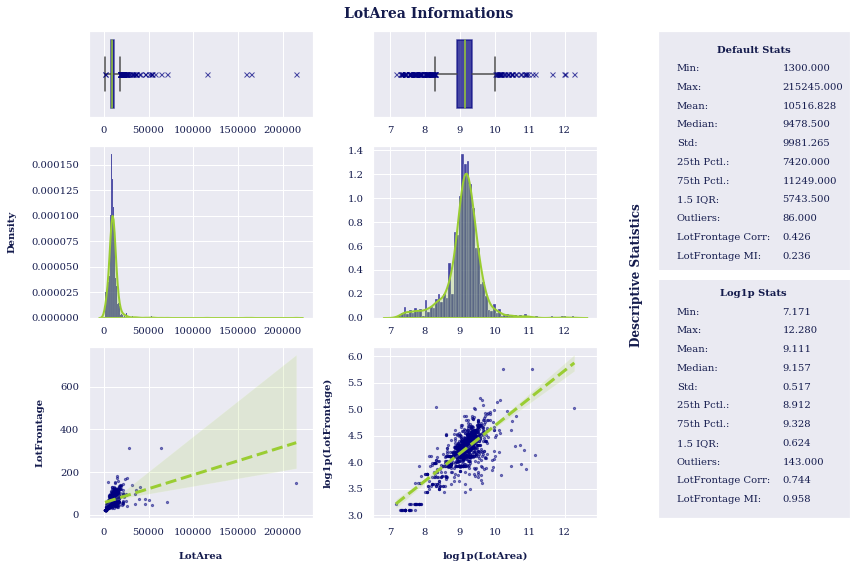

In [755]:
numerical_handler.numerical_info_plot("LotArea", "LotFrontage")

Again, there is a better way to fill in these values - build a linear regression model. We will create a simple class with a `LinearRegression` estimator to handle these NaNs.

In [756]:
from sklearn.base import clone, check_is_fitted
from sklearn.linear_model import LinearRegression


class LotFrontageImputer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=LinearRegression()):
        self.estimator = estimator

    def fit(self, X, y=None):
        train_mask = ~X["LotFrontage"].isna()
        X_train = X.loc[train_mask, "LotArea"]
        y_train = X.loc[train_mask, "LotFrontage"]

        X_prepared = np.log1p(X_train.values.reshape(-1, 1))
        y_prepared = np.log1p(y_train.values)

        estimator_ = clone(self.estimator)
        estimator_.fit(X_prepared, y_prepared)  # type: ignore

        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_  # type: ignore

        if hasattr(self.estimator, "feature_names_in"):
            self.feature_names_in_ = self.estimator.feature_names_in_

        return self

    def transform(self, X, y=None):
        check_is_fitted(self)

        missing_mask = X["LotFrontage"].isna()
        self.missing_mask_ = missing_mask

        if missing_mask.sum() == 0:
            return X

        X = X.copy()
        X_missing = X.loc[missing_mask, "LotArea"]
        X_prepared = np.log1p(X_missing.values.reshape(-1, 1))

        predictions = self.estimator_.predict(X_prepared)  # type: ignore
        X.loc[missing_mask, "LotFrontage"] = np.expm1(predictions)

        return X


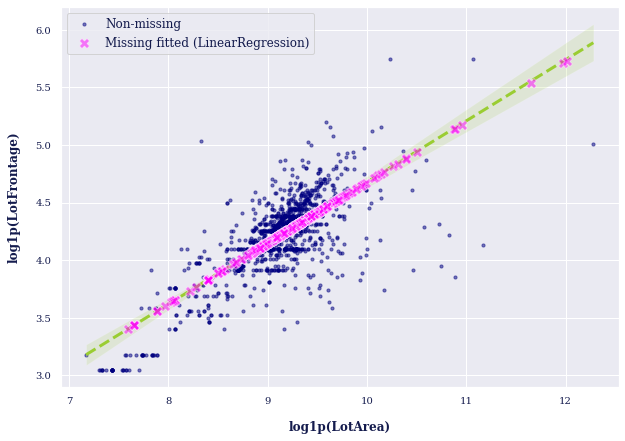

In [757]:
lfi = LotFrontageImputer()
result = lfi.fit_transform(train_set)

x_initial = np.log(result.loc[~lfi.missing_mask_, "LotArea"])
y_initial = np.log(result.loc[~lfi.missing_mask_, "LotFrontage"])

x_predicted = np.log(result.loc[lfi.missing_mask_, "LotArea"])
y_predicted = np.log(result.loc[lfi.missing_mask_, "LotFrontage"])

plt.figure(figsize=(10, 7))

skws = {"alpha": 0.5, "s": 10, "color": "navy"}
lkws = {"linewidth": 3, "linestyle": "--", "color": "yellowgreen"}
sns.regplot(x=x_initial, y=y_initial, scatter_kws=skws, line_kws=lkws, label="Non-missing")
sns.scatterplot(
    x=x_predicted,
    y=y_predicted,
    alpha=0.5,
    color="magenta",
    s=100,
    zorder=2,
    marker="X",
    label=f"Missing fitted ({lfi.estimator_.__class__.__name__})",
)
plt.legend(fontsize=12)
plt.xlabel("log1p(LotArea)", fontsize=12)
plt.ylabel("log1p(LotFrontage)", fontsize=12)
plt.show()


In [758]:
from scipy.stats import pearsonr

init_corr, _ = pearsonr(np.log(x_initial), np.log(y_initial))
fit_corr, _ = pearsonr(np.log(result["LotArea"]), np.log(result["LotFrontage"]))

print("Correlation without missing values:".ljust(40), f"{init_corr:.5f}")
print("Correlation including fitted values:".ljust(40), f"{fit_corr:.5f}")


Correlation without missing values:      0.77268
Correlation including fitted values:     0.78935


In [759]:
custom_preproc = make_pipeline(
    CustomImputer(),
    LotFrontageImputer(),
    CustomCategoricalTransformer(),
    CustomNumericalTransformer(),
)

train_custom_preproc = custom_preproc.fit_transform(train_set.drop("SalePrice", axis=1))
train_custom_preproc.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BasementFinished,IsBasementBath,IsWoodDeck,IsPorch,IsHalfBathroom,IsSecondFloor,IsMasonryArea,IsFireplace
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Brick,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,Warranty,Normal,0,1,0,1,1,1,1,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR,Gtl,2,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,Warranty,Normal,0,1,1,0,0,0,0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Brick,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,Warranty,Normal,0,1,0,1,1,1,1,1
3,4,70,RL,60.0,9550,Pave,NaN,IR,Lvl,AllPub,Corner,Gtl,2,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,Warranty,Abnorml,0,1,0,1,0,1,0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR,Lvl,AllPub,FR,Gtl,4,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Brick,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,Warranty,Normal,0,1,1,1,1,1,1,1


In [760]:
train_custom_preproc.isna().sum()[train_custom_preproc.isna().sum() > 0]


Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtExposure       1
BsmtFinType2       1
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [761]:
test_custom_preproc = custom_preproc.transform(test_set)
test_custom_preproc.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BasementFinished,IsBasementBath,IsWoodDeck,IsPorch,IsHalfBathroom,IsSecondFloor,IsMasonryArea,IsFireplace
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,Warranty,Normal,0,0,1,1,0,0,0,0
1,1462,20,RL,81.0,14267,Pave,NaN,IR,Lvl,AllPub,Corner,Gtl,1,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,Brick,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,Warranty,Normal,0,0,1,1,1,0,1,0
2,1463,60,RL,74.0,13830,Pave,NaN,IR,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,Warranty,Normal,0,0,1,1,1,1,0,1
3,1464,60,RL,78.0,9978,Pave,NaN,IR,Lvl,AllPub,Inside,Gtl,2,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,Brick,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,Warranty,Normal,0,0,1,1,1,1,1,1
4,1465,120,RL,43.0,5005,Pave,NaN,IR,HLS,AllPub,Inside,Gtl,4,Norm,Norm,Twnhs,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,0.0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,Warranty,Normal,0,0,0,1,0,0,0,0


In [762]:
test_custom_preproc.isna().sum()[test_custom_preproc.isna().sum() > 0]

MSZoning           4
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual           3
BsmtCond           4
BsmtExposure       3
BsmtFinType1       1
BsmtFinSF1         1
BsmtFinType2       1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt        2
GarageFinish       2
GarageCars         1
GarageArea         1
GarageQual         2
GarageCond         2
PoolQC          1456
Fence           1169
MiscFeature     1408
dtype: int64

Good! Nevertheless, there are still missing values, but we decided to drop the like `Alley`, `PoolQC` etc., so it's not the problem. In the case of the rest, we will use the median and most frequent strategies.

---

<a id="feature-engineering"></a>
# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">3. FEATURE ENGINEERING</p>

In [763]:
class NewFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")

        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(X.columns, dtype=object)

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame.")
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features.")

        X = X.copy()

        X["HouseAge"] = X["YrSold"] - X["YearBuilt"]
        X["IsRemod"] = (X["YearRemodAdd"] > X["YearBuilt"]).astype(np.uint8)
        X["LivAreaQuality"] = X["GrLivArea"] * X["OverallQual"]
        X["BsmtAreaQuality"] = X["TotalBsmtSF"] * X["BsmtQual"].map(
            {"NA": 1, "Po": 2, "Fa": 3, "TA": 4, "Gd": 5, "Ex": 6}
        )

        return X


---

In [764]:
tmp = NewFeatureAdder().fit_transform(train_set)
tmp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HouseAge,IsRemod,LivAreaQuality,BsmtAreaQuality
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5,0,11970,4280.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,31,0,7572,6310.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,7,1,12502,4600.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,91,1,12019,3024.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,8,0,17584,5725.0


<a id="auto-preproc"></a>
# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">4. AUTO PREPROCESSING PIPELINES</p>

---

In [765]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    MinMaxScaler,
)

hot_encoder = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
)

ord_encoder = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

log1p_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, np.expm1),
)

identity_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(),
)

min_max_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler(),
)


In [766]:
from sklearn.compose import make_column_transformer

ord_encoder2 = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)

auto_preproc = make_column_transformer(
    (
        hot_encoder,
        [
            "LotShape",
            "LotConfig",
            "MSZoning",
            "Condition1",
            "BldgType",
            "HouseStyle",
            "RoofStyle",
            "Exterior1st",
            "MasVnrType",
            "Foundation",
            "CentralAir",
            "Electrical",
            "GarageType",
            "GarageFinish",
            "SaleType",
            "SaleCondition",
            # Added.
            "BasementFinished",
            "IsBasementBath",
            "IsWoodDeck",
            "IsPorch",
            "IsHalfBathroom",
            "IsSecondFloor",
            "IsMasonryArea",
            "IsFireplace",
            "IsRemod",
        ],
    ),
    (
        ord_encoder,
        [
            "LandContour",
            "ExterQual",
            "ExterCond",
            "PavedDrive",
            "HeatingQC",
            "KitchenQual",
            "FireplaceQu",
            "BsmtQual",
            "BsmtCond",
            "BsmtExposure",
            "BsmtFinType1",
            "BsmtFinType2",
            "GarageQual",
            "GarageCond",
        ],
    ),
    (
        log1p_transformer,
        [
            "LotFrontage",
            "LotArea",
            "1stFlrSF",
            # Added.
            "LivAreaQuality",
            "BsmtAreaQuality",
        ],
    ),
    (
        min_max_transformer,
        [
            # Added.
            "HouseAge",
        ],
    ),
    (
        identity_transformer,
        [
            "Neighborhood",  # We encoded `Neighborhood` on our's own.
            "FullBath",
            "GarageCars",
            "BedroomAbvGr",
            "OverallQual",
            "OverallCond",
        ],
    ),
    # All features not in the above lists will be dropped at the final stage.
    remainder="drop",
)


In [767]:
preprocessing = make_pipeline(
    CustomImputer(),
    LotFrontageImputer(),
    CustomCategoricalTransformer(),
    CustomNumericalTransformer(),
    NewFeatureAdder(),
    auto_preproc,
)

In [768]:
tmp = preprocessing.fit_transform(train_set)
tmp

array([[0., 1., 0., ..., 3., 7., 5.],
       [0., 1., 0., ..., 3., 6., 8.],
       [1., 0., 0., ..., 3., 7., 5.],
       ...,
       [0., 1., 0., ..., 4., 7., 9.],
       [0., 1., 0., ..., 2., 5., 6.],
       [0., 1., 0., ..., 3., 5., 6.]])

<a id="ml"></a>
# <p style="padding:20px; background-color:#141b4d; font-family:fantasy; font-weight:normal; color:#f2f2f0; font-size:150%; text-align:center; border-radius: 20px 20px">5. MACHINE LEARNING</p>

In [769]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    Ridge,
    RidgeCV,
    Lasso,
    SGDRegressor,
)
from sklearn.svm import LinearSVR
from scipy.stats import randint, uniform

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

train_labels = train_set["SalePrice"]
train_set = train_set.drop("SalePrice", axis=1)

voting_reg = VotingRegressor(
    [
        ("forest", RandomForestRegressor()),
        ("gbc", GradientBoostingRegressor()),
        ("ridge", RidgeCV()),
        ("lasso", Lasso(alpha=0.001)),
        ("xgb", XGBRegressor()),
        ("lgbm", LGBMRegressor()),
    ],
    verbose=True,
    n_jobs=-1,
)

full_pipeline = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(
        voting_reg,
        func=np.log,
        inverse_func=np.exp,
    ),
    # verbose=True,
)

#full_pipeline.fit(train_set, train_labels)

rmses = -cross_val_score(
    full_pipeline,
    train_set,
    train_labels,
    cv=5,
    scoring="neg_root_mean_squared_error",
    error_score="raise",  # type: ignore
)
pd.Series(rmses).describe()
# 25379.477102


count        5.000000
mean     25582.741318
std       3414.130237
min      20942.313337
25%      22941.617529
50%      27466.956129
75%      28272.871086
max      28289.948507
dtype: float64

In [770]:
full_pipeline.fit(train_set, train_labels)
results = full_pipeline.predict(test_set)

df = pd.DataFrame({"Id": test_set["Id"], "SalePrice": results})
df.set_index("Id").to_csv("data/submission.csv")
df

,Id,SalePrice
0,1461,112982.848307
1,1462,159779.521643
2,1463,174940.509305
3,1464,190413.162488
4,1465,194163.692567
...,...,...
1454,2915,86368.898153
1455,2916,78539.053643
1456,2917,156893.095401
1457,2918,122586.612981


In [771]:
from sklearn.model_selection import RandomizedSearchCV


estimator = make_pipeline(
    preprocessing,
    TransformedTargetRegressor(
        LGBMRegressor(random_state=42),
        func=np.log,
        inverse_func=np.exp,
    ),
)

# rmses = -cross_val_score(
#     estimator,
#     train_set,
#     train_labels,
#     cv=5,
#     scoring="neg_root_mean_squared_error",
#     error_score="raise",  # type: ignore
# )
# pd.Series(rmses).describe()

param_dist = {
    "transformedtargetregressor__regressor__n_estimators": [50, 75, 100, 125, 150],
    "transformedtargetregressor__regressor__max_depth": [5, 10, 15, 20, 25],
    "transformedtargetregressor__regressor__learning_rate": [0.01, 0.03, 0.1, 0.3],
}

rnd_search = RandomizedSearchCV(
    estimator,
    param_distributions=param_dist,
    cv=5,
    n_iter=100,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    random_state=42,
)
rnd_search.fit(train_set, train_labels);
-rnd_search.best_score_

26826.860545803716

In [772]:
rnd_search.best_params_

{'transformedtargetregressor__regressor__n_estimators': 125,
 'transformedtargetregressor__regressor__max_depth': 20,
 'transformedtargetregressor__regressor__learning_rate': 0.1}